<a href="https://colab.research.google.com/github/Bienbaz/Bienbaz/blob/main/AI_Malware_Forensics_Detecting_Anomalies_in_PE_Headers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries (usually pre-installed in Colab, but good practice)
!pip install pandas numpy scikit-learn seaborn matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# 1. Trigger the upload widget
print("Please upload your 'Malware dataset.csv' file...")
uploaded = files.upload()

# 2. Get filename and read data
filename = list(uploaded.keys())[0]
print(f"Successfully uploaded: {filename}")

# 3. Load into Pandas
# Note: The separator might be '|' or ',' depending on the specific version of the dataset.
# We try standard comma first. If it looks wrong, change sep=',' to sep='|'
df = pd.read_csv(io.BytesIO(uploaded[filename]), sep=',')

# 4. Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Quick forensic preview
print(f"Dataset Shape: {df.shape}")
df.head()

Please upload your 'Malware dataset.csv' file...


Saving Malware dataset.csv to Malware dataset.csv
Successfully uploaded: Malware dataset.csv
Dataset Shape: (100000, 35)


,hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,...,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
0,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914...,0,malware,0,0,3069378560,14274,0,0,0,...,0,0,120,0,3204448256,380690,4,0,0,0
1,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914...,1,malware,0,0,3069378560,14274,0,0,0,...,0,0,120,0,3204448256,380690,4,0,0,0
2,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914...,2,malware,0,0,3069378560,14274,0,0,0,...,0,0,120,0,3204448256,380690,4,0,0,0
3,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914...,3,malware,0,0,3069378560,14274,0,0,0,...,0,0,120,0,3204448256,380690,4,0,0,0
4,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914...,4,malware,0,0,3069378560,14274,0,0,0,...,0,0,120,0,3204448256,380690,4,0,0,0


In [4]:
# 1. Define the Target
# In most Kaggle malware datasets, the target column is named 'legitimate' or 'Label'
# legitimate: 1 = Safe, 0 = Malware (Double check your specific dataset!)
target_col = 'classification'

# 2. Drop non-predictive metadata (Forensic Hygiene)
# We remove 'Name' and 'md5' because the AI should learn *structure*, not specific filenames.
drop_cols = ['hash', 'md5', target_col]

# Check if columns exist before dropping to avoid errors
existing_drop_cols = [col for col in drop_cols if col in df.columns]
X = df.drop(existing_drop_cols, axis=1)
y = df[target_col]

# 3. Split the Evidence (Train/Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Forensic Training Samples: {X_train.shape[0]}")
print(f"Forensic Testing Samples: {X_test.shape[0]}")

Forensic Training Samples: 80000
Forensic Testing Samples: 20000


In [5]:
# Initialize the Forensic Classifier
clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,   # Ensures reproducible results
    max_depth=20       # Prevents the model from memorizing the data (Overfitting)
)

# Train the model
print("Analyzing PE Headers... Training in progress...")
clf.fit(X_train, y_train)
print("Training Complete.")

Analyzing PE Headers... Training in progress...
Training Complete.


Model Accuracy: 100.00%


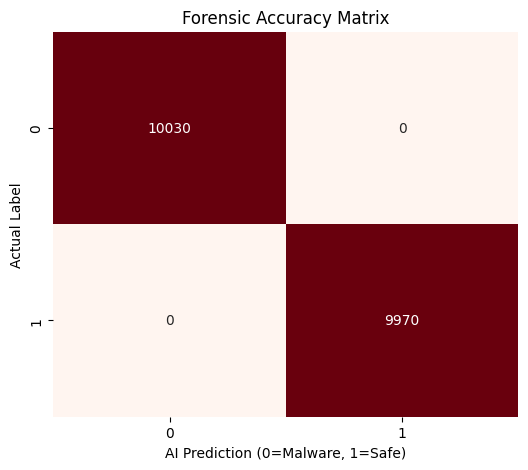


Classification Report:
               precision    recall  f1-score   support

      benign       1.00      1.00      1.00     10030
     malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [6]:
# 1. Predict
y_pred = clf.predict(X_test)

# 2. Accuracy Check
print(f"Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

# 3. Confusion Matrix Visualization
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Forensic Accuracy Matrix')
plt.xlabel('AI Prediction (0=Malware, 1=Safe)')
plt.ylabel('Actual Label')
plt.show()

# 4. Detailed Forensic Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

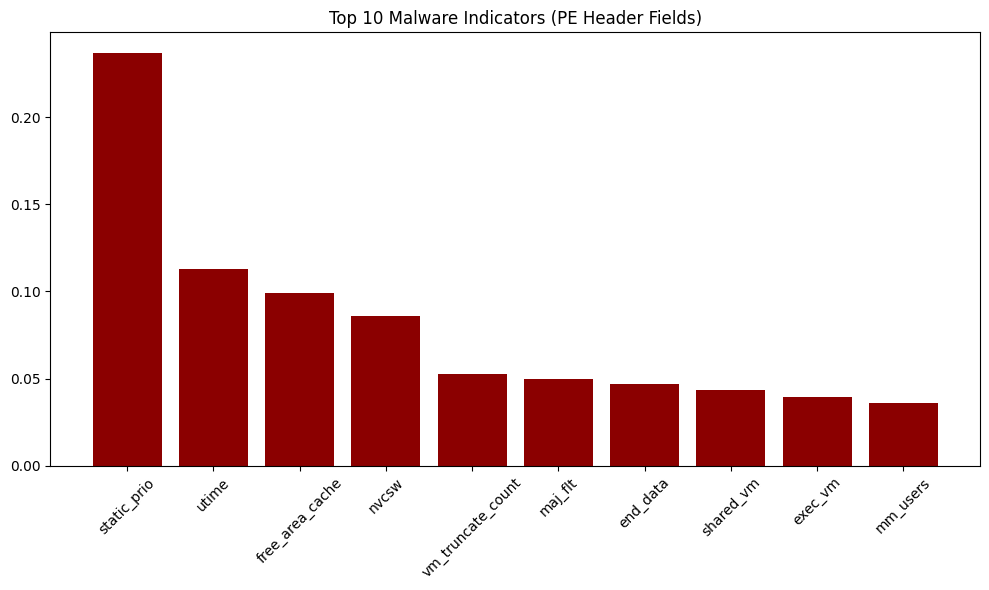

In [7]:
# Extract feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

# Plot Top 10 Suspicious Features
plt.figure(figsize=(10,6))
plt.title('Top 10 Malware Indicators (PE Header Fields)')
plt.bar(range(10), importances[indices[:10]], align="center", color='darkred')
plt.xticks(range(10), X.columns[indices[:10]], rotation=45)
plt.tight_layout()
plt.show()